In [14]:
import basedosdados as bd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
df = bd.read_sql(
    '''
    WITH sim AS(
    SELECT
    sigla_uf,
    id_municipio,
    SUM(numero_obitos) as total_obitos
    FROM `basedosdados.br_ms_sim.municipio_causa` 
    WHERE (causa_basica LIKE 'T60%'
        OR causa_basica LIKE 'X48%'
        OR causa_basica LIKE 'X68%'
        OR causa_basica LIKE 'X87%'
        OR causa_basica LIKE 'Y18%'
        OR causa_basica LIKE 'Z574') AND ano > 2017
    GROUP BY sigla_uf, id_municipio
    ORDER BY total_obitos DESC
    ),

    censo AS(
    SELECT
    id_municipio,
    despesa_defensivos/numero_estabelecimentos_total as razao_defensivos,
    despesa_adubos/numero_estabelecimentos_total as razao_adubos
    FROM `basedosdados.br_ibge_censo_agropecuario.municipio` 
    WHERE ano = 2017 AND numero_estabelecimentos_total > 0
    ),

    pop AS(
    SELECT * 
    FROM `basedosdados.br_ibge_populacao.municipio`
    WHERE ano = 2017

    ),


    diretorios AS(
    SELECT id_municipio, nome 
    FROM `basedosdados.br_bd_diretorios_brasil.municipio`

    )
    SELECT t1.*, t2.*, t3.*, t4.*
    FROM sim t1
    LEFT JOIN censo t2 
        ON t1.id_municipio = t2.id_municipio
    LEFT JOIN diretorios t3
        ON t2.id_municipio = t3.id_municipio
    LEFT JOIN pop t4
        ON t3.id_municipio = t4.id_municipio
    ORDER BY t1.total_obitos DESC
    ''', 
    billing_project_id = 'casebd'
)

Downloading: 100%|██████████| 577/577 [00:00<00:00, 1458.26rows/s]


In [24]:
df.dtypes


sigla_uf             object
id_municipio         object
total_obitos          Int64
id_municipio_1       object
razao_defensivos    float64
razao_adubos        float64
id_municipio_2       object
nome                 object
ano                   Int64
sigla_uf_1           object
id_municipio_3       object
populacao             Int64
dtype: object

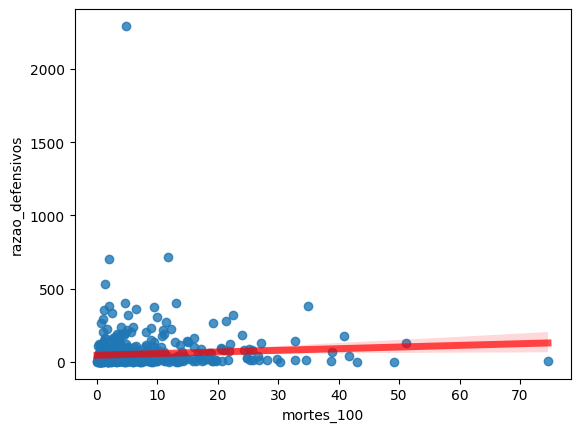

In [25]:
df["total_obitos"] = df["total_obitos"].astype('float64')
df["mortes_100"] = (df["total_obitos"]/df["populacao"]) * 100000
sns.regplot(x = df["mortes_100"], y = df["razao_defensivos"], line_kws={"color":"r","alpha":0.7,"lw":5})

plt.show()


In [26]:
df.groupby(by = "sigla_uf").sum()


,total_obitos,razao_defensivos,razao_adubos,ano,populacao,mortes_100
sigla_uf,,,,,,
AL,18.0,489.766474,0.000000,24204,581665,57.642491
AM,4.0,252.504492,0.000000,6051,106936,17.027859
AP,1.0,22.000000,0.000000,2017,15125,6.611570
BA,73.0,1356.051998,0.000000,74629,5728453,134.139827
CE,41.0,300.620040,0.000000,66561,4236410,144.659477
DF,11.0,25.444444,0.000000,2017,3039444,0.361908
ES,29.0,592.021853,0.000000,42357,856234,105.553713
GO,46.0,1779.167839,0.000000,54459,3289044,245.612937
MA,31.0,932.102446,0.039474,48408,2276258,127.293788
